In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import copy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

Using TensorFlow backend.


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data=pd.read_csv('gdrive/My Drive/bank-additional-full.csv')

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [ ]:
data.drop(['duration'], axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_encoded = data.apply(le.fit_transform)
print(data_encoded) 

       age  job  marital  education  ...  cons.conf.idx  euribor3m  nr.employed  y
0       39    3        1          0  ...             16        287            8  0
1       40    7        1          3  ...             16        287            8  0
2       20    7        1          3  ...             16        287            8  0
3       23    0        1          1  ...             16        287            8  0
4       39    7        1          3  ...             16        287            8  0
...    ...  ...      ...        ...  ...            ...        ...          ... ..
41183   56    5        1          5  ...              0        171            0  1
41184   29    1        1          5  ...              0        171            0  0
41185   39    5        1          6  ...              0        171            0  0
41186   27    9        1          5  ...              0        171            0  1
41187   57    5        1          5  ...              0        171            0  0

[41

In [ ]:
data_encoded.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39,3,1,0,0,0,0,1,6,1,261,0,26,0,1,8,18,16,287,8,0
1,40,7,1,3,1,0,0,1,6,1,149,0,26,0,1,8,18,16,287,8,0
2,20,7,1,3,0,2,0,1,6,1,226,0,26,0,1,8,18,16,287,8,0
3,23,0,1,1,0,0,0,1,6,1,151,0,26,0,1,8,18,16,287,8,0
4,39,7,1,3,0,0,2,1,6,1,307,0,26,0,1,8,18,16,287,8,0


In [ ]:
'''
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c] = pd.factorize(data[c])[0]
    '''

"\nchar_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index\n\nfor c in char_cols:\n    data[c] = pd.factorize(data[c])[0]\n    "

In [ ]:
'''
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index
label_mapping = {}

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

  '''

"\nchar_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index\nlabel_mapping = {}\n\nfor c in char_cols:\n    data[c], label_mapping[c] = pd.factorize(data[c])\n\n  "

In [ ]:
X = data_encoded.drop('y', axis=1)
Y = data_encoded['y']

In [ ]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,39,3,1,0,0,0,0,1,6,1,261,0,26,0,1,8,18,16,287,8
1,40,7,1,3,1,0,0,1,6,1,149,0,26,0,1,8,18,16,287,8
2,20,7,1,3,0,2,0,1,6,1,226,0,26,0,1,8,18,16,287,8
3,23,0,1,1,0,0,0,1,6,1,151,0,26,0,1,8,18,16,287,8
4,39,7,1,3,0,0,2,1,6,1,307,0,26,0,1,8,18,16,287,8


In [ ]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [ ]:
df=np.array(X) 
target=np.array(Y) 

In [ ]:
####We can define these data as a matrix of 20 columns with 41188 rows:
#data = data.reshape(1, 41188, 20)

In [ ]:
df.shape  

(41188, 20)

In [ ]:
target.shape

(41188,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target, test_size=0.2, random_state=10)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=56)

In [ ]:
print('x_train = ', x_train.shape, '\ny_train = ', y_train.shape)
print('x_test = ', x_test.shape, '\ny_test = ', y_test.shape)
print('x_valid = ', x_valid.shape, '\ny_valid = ', y_valid.shape)

x_train =  (24712, 20) 
y_train =  (24712,)
x_test =  (8238, 20) 
y_test =  (8238,)
x_valid =  (8238, 20) 
y_valid =  (8238,)


In [ ]:
np.shape(x_train)

(24712, 20)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(24712, 20, 1)
(8238, 20, 1)
(8238, 20, 1)


In [ ]:
#x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
#x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
#x_valid = np.reshape(x_valid,(x_valid.shape[0], 1, x_valid.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.contrib.keras.api.keras import layers
from tensorflow.contrib.keras.api.keras.layers import Dense, LSTM, Bidirectional, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import optimizers

ModuleNotFoundError: ignored

In [ ]:
model_new = Sequential()
model_new.add(Bidirectional(LSTM(100, return_sequences=True), batch_input_shape=(None,11,48), merge_mode='ave'))
model_new.add(BatchNormalization())
model_new.add(Bidirectional(LSTM(100, return_sequences=True), batch_input_shape=(None,11,48), merge_mode='ave'))
model_new.add(BatchNormalization())
model_new.add(Flatten())
model_new.add(Dense(100, activation='sigmoid'))
model_new.add(BatchNormalization())
model_new.add(Dense(32, activation='sigmoid'))
model_new.add(BatchNormalization())
model_new.add(Dense(2, activation='softmax'))

adam=tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_new.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_new.summary()

In [ ]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Checkpoint = ModelCheckpoint( 'hist',monitor='acc', 
                           verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history=model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, callbacks=[Checkpoint], batch_size=256, verbose=1, shuffle=True)
# model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=2048, verbose=1, shuffle=True)
# model.save('m.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 24712 samples, validate on 8238 samples
Epoch 1/100





24712/24712 [==============================] - 5s 203us/step - loss: 0.1338 - acc: 0.8455 - val_loss: 0.0888 - val_acc: 0.8825

Epoch 00001: acc improved from -inf to 0.84554, saving model to hist
Epoch 2/100
24712/24712 [==============================] - 4s 147us/step - loss: 0.0827 - acc: 0.8922 - val_loss: 0.0869 - val_acc: 0.8832

Epoch 00002: acc improved from 0.84554 to 0.89220, saving model to hist
Epoch 3/100
24712/24712 [==============================] - 4s 145us/step - loss: 0.0791 - acc: 0.8972 - val_loss: 0.0735 - val_acc: 0.8988

Epoch 00003: acc improved from 0.89220 to 0.89722, saving model to hist
Epoch 4/100
24712/24712 [==============================] - 4s 142us/step - loss: 0.0662 - acc: 0.9058 - val_loss: 0.0657 - val_acc: 0.9028

Epoch 00004: acc improved from 0.89722 to 0.90584, saving model to hist
Epoc

In [ ]:
from keras.models import load_model

model = load_model('hist') 

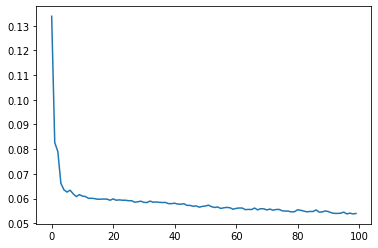

In [ ]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# make predictions

y_pred = model.predict(x_train)

In [ ]:
print (y_train.shape , y_pred.shape)

(24712,) (24712, 1)


In [ ]:
from sklearn.preprocessing import Binarizer
transformer = Binarizer().fit(y_pred)  # fit does nothing.
transformer
y_pred=transformer.transform(y_pred)

In [ ]:
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score
# Print the prediction accuracy
print (metrics.accuracy_score(y_train, y_pred))

0.5937601165425704


In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     21959
           1       0.21      0.99      0.35      2753

    accuracy                           0.59     24712
   macro avg       0.61      0.77      0.53     24712
weighted avg       0.91      0.59      0.66     24712



In [ ]:
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


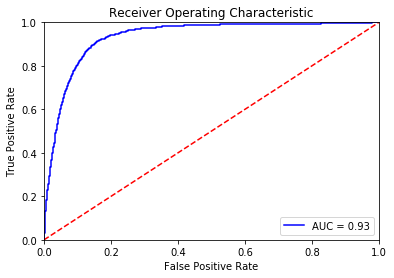

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(x_test)
preds = probs 
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
